<a href="https://colab.research.google.com/github/cristi2019255/TextMining/blob/main/Data_mining_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import string
import re
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [ ]:
!{sys.executable} -m pip install nltk sklearn scipy

/bin/bash: {sys.executable}: command not found


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag          
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import classification_report
from scipy import stats


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import mutual_info_classif

# Utils

In [ ]:
def evaluate_pred(Y_test, Y_pred):            
    print("Number of mislabeled points out of a total %d points : %d"
       % (len(Y_test), (Y_test != Y_pred).sum()))    
    print('acc: ', accuracy_score(Y_test, Y_pred))
    print('precision: ', precision_score(Y_test,Y_pred))
    print('recall: ', recall_score(Y_test,Y_pred))
    print('F: ', f1_score(Y_test,Y_pred))
    return accuracy_score(Y_test, Y_pred)

# Loading Data

In [ ]:
# first load in the reviews into a corpus
def get_corpus(data_path):
    corpus, Y = [], []    
    file_nr = 0
    '''reads all thruthful negative reviews, prepares the text, and adds it to the corpus'''    
    for review_type in ['deceptive_from_MTurk', 'truthful_from_Web']:              
        for fold in ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']:            
            for file in os.listdir(os.path.join(data_path, review_type , fold)):
                file_path = os.path.join(data_path, review_type, fold, file)
                
                # open review
                with open(file_path, "r") as f:
                    raw_review = f.read()                  
                corpus.append(raw_review)
                file_nr +=1
                if (file_nr % 100 == 0):
                  print(file_nr)                
                Y.append(0 if review_type == 'deceptive_from_MTurk' else 1)                                 
    return corpus, Y

# defining stop words
stop_words = set(stopwords.words('english'))

# defining lemmatization 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, review):
        review = review.translate(str.maketrans("","", string.punctuation)) # remove punctuation
        review = re.sub(r'\d+', '', review) # remove numbers
        return [self.wnl.lemmatize(token) for token in word_tokenize(review) if token not in stop_words]

# defining steamming
class SteammingTokenizer(object):
    def __init__(self):
        self.stemmer = PorterStemmer()        
    def __call__(self, review):
        review = review.translate(str.maketrans("","", string.punctuation)) # remove punctuation
        review = re.sub(r'\d+', '', review) # remove numbers
        return [self.stemmer.stem(token) for token in word_tokenize(review) if token not in stop_words]

# defining POS
class POSTokenizer(object):
    def __init__(self, lemmatizer = False, select = False):         
        self.wnl = WordNetLemmatizer() 
        self.lemmatization = lemmatizer 
        self.select = select
    def __call__(self, review):        
        review = review.translate(str.maketrans("","", string.punctuation)) # remove punctuation
        review = re.sub(r'\d+', '', review) # remove numbers
        tokens = [token for token in pos_tag(word_tokenize(review)) if token[0] not in stop_words]                                
        if self.select:
          return [token[0]+" "+token[1] for token in tokens if (('NN' in token[1])or('VB' in token[1])) ]
        if self.lemmatization:          
          tokens = [self.wnl.lemmatize(token[0])+" "+token[1] for token in tokens]          
        else:
          tokens = [token[0]+" "+token[1] for token in tokens]
        return tokens


# getting the words frequences
def vectorize(corpus, n_grams = 2, min_df = 0.01, max_df = 0.95, method='lemmatize'):  
  dictionary = {
      'lemmatize': LemmaTokenizer(),
      'stemming':  SteammingTokenizer(),
      'pos': POSTokenizer(),
      'pos_lemmatize': POSTokenizer(lemmatizer = True),
      'pos_select': POSTokenizer(select=True),
      'tokenizer': RegexpTokenizer(r'[a-zA-Z]+').tokenize # to remove unwanted elements from out data like symbols and numbers
  }  
  tokenizer = dictionary[method]

  vectorizer = TfidfVectorizer(
                               lowercase=True,
                               ngram_range = (1,n_grams),                              
                               tokenizer = tokenizer, 
                               min_df = min_df, #remove terms with minimum document frequency as known as removing sparse terms
                               max_df= max_df #remove most frequent terms as they might be not interesting
                               )
  X = vectorizer.fit_transform(corpus).toarray()
  feature_names = vectorizer.get_feature_names_out()
  return X, feature_names

  
## running to long need to be imporved
def mutual_info_feature_selection(X, Y, feature_names, trashold=0.01, top_k=300, method='top'):    
  mutual_info = mutual_info_classif(X, Y, random_state=0)  
  print(len(mutual_info))
  if method == 'top':      
    top_values = list(mutual_info)
    top_values.sort()
    top_values = top_values[::-1][:top_k] # ordering descending and taking best k
    feature_indx = [True if (mutual_info[i] in top_values) else False for i in range(len(mutual_info))]
  else:
    feature_indx = mutual_info > trashold  
  return X[:,feature_indx], feature_indx, mutual_info[feature_indx]


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Data_mining_assignment_2021_2/op_spam_v1.4/negative_polarity"
corpus, Y = get_corpus(DATA_PATH)
X, feature_names = vectorize(corpus, method='pos', n_grams=1)
print(feature_names)
print(len(feature_names))

100
200
300
400
500
600
700
800
['able JJ' 'absolutely RB' 'ac NN' ... 'yet RB' 'young JJ' 'youre NN']
1351


In [ ]:
# Used for testing what preprocess technique is the best
naive_bayes = MultinomialNB().fit(X, Y)
Y_pred = naive_bayes.predict(X)
print(accuracy_score(Y_pred,Y))

0.96125


# Feature selection

In [ ]:
X_mutual, feature_indx, info_values = mutual_info_feature_selection(X, Y, feature_names, method='percentage', trashold=0.005)
feature_selected = np.array(feature_names)[np.array(feature_indx)]
feature_names = np.array(feature_names)[np.array(feature_indx)]
print('selected nr of features: ',len(feature_selected))
print(feature_selected[:10])
X = X_mutual.copy()

1351
selected nr of features:  562
['absolutely RB' 'access NN' 'accommodations NNS' 'actual JJ' 'advance NN'
 'affinia JJ' 'affinia NN' 'afternoon NN' 'ago IN' 'allowed VBN']


In [ ]:
# Used for testing what feature extration technique is the best
naive_bayes = MultinomialNB().fit(X_mutual, Y)
Y_pred = naive_bayes.predict(X_mutual)
print(accuracy_score(Y_pred,Y))

0.91375


In [ ]:
# spliting into train and test: fold5 for test others for training and parameter tuning

n = len(X)
X_train = np.concatenate((X[:int(n*0.4)],X[int(n*0.5):int(n*0.9)]))
X_test = np.concatenate((X[int(n*0.4):int(n*0.5)], X[int(n*0.9):]))
Y_train, Y_test = Y[:int(n*0.4)] + Y[int(n*0.5):int(n*0.9)], Y[int(n*0.4):int(n*0.5)] + Y[int(n*0.9):]


#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=0)

In [ ]:
# Used for testing what preprocess technique is the best
naive_bayes = MultinomialNB().fit(X_train, Y_train)
Y_pred = naive_bayes.predict(X_test)
print(accuracy_score(Y_pred,Y_test))

0.775


# Use Cross-Validation to select the best hyperparameters!

In [ ]:
cv = 5

def parameter_tunning_naive_baiyes(X, Y):    
  #  To do: splitting data into 10 folders for cross validation
  '''
    Naive Bayes
  '''
  cv = KFold(5, shuffle=True, random_state=0) 
  # naive bayes has no parameters to be tunned
  naive_bayes = MultinomialNB()
  print(f'Cross validation for naive bayes:')
  cross_val_scores = cross_val_score(naive_bayes, X, Y, cv=cv, n_jobs=-1)
  print(cross_val_scores)
  plt.plot(cross_val_scores, marker='o', linestyle="None")

def parameter_tunning_logistic_regresion(X, Y):    
  '''
    Logistic regresion
  '''
  # performing a Grid Search on lambda to tunne it for logistic regresion
  C = [10**x for x in np.arange(5.0,-5.0,-0.1)]  
  grid_search_lr = GridSearchCV(
                      cv=cv,
                      estimator=LogisticRegression( solver='liblinear', 
                                                    penalty='l1',
                                                    random_state=0,                                                    
                                                    ),
                      param_grid={'C': C },   # C = 1/lambda                   
                      n_jobs=-1
                    )
  grid_result = grid_search_lr.fit(X, Y)
  best_lambda = grid_result.best_params_['C']
  print(f'best lambda for logistic regresion is: {best_lambda}')
  
  '''
    ploting results
  '''
  fig, ax = plt.subplots()
  ax.set_title('log lambda vs accuracy score for logistic regresion')
  ax.set_xlabel('log lambda')
  ax.set_ylabel('accuracy score')
  ax.errorbar([x for x in np.arange(-5.0,5.0,0.1)], grid_result.cv_results_['mean_test_score'], yerr = grid_result.cv_results_['std_test_score'], fmt='.k', linestyle='None')
  return best_lambda

def parameter_tunning_random_forest(X, Y):    
  '''
    Random forest
  '''  
  # Grid search on Random Forest to tunne n_estimators - number of trees used and max_features
  model = RandomForestClassifier()
  n_estimators = [x for x in range(10,1000,10)]
  max_features = ['sqrt', 'log2']
  grid = {'max_features':max_features, 'n_estimators':n_estimators}
  grid_search = GridSearchCV(
                             estimator= RandomForestClassifier(),
                             param_grid=grid, 
                             n_jobs=-1, 
                             cv=cv, 
                             scoring='accuracy',
                             error_score=0
                             )
  grid_result = grid_search.fit(X, Y)

  # summarize results for random forest
  max_features, n_estimators = grid_result.best_params_['max_features'], grid_result.best_params_['n_estimators']
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  # print("MEAN (STD) with: PARAMS")
  # for mean, stdev, param in zip(means, stds, params):
  #  print("%f (%f) with: %r" % (mean, stdev, param))
  
  '''
    plotting results
  '''
  fig, ax1 = plt.subplots()
  
  ax1.set_title('max_features sqrt')  
  ax1.set_xlabel('number of trees')
  ax1.set_ylabel('accuracy score')
  ax1.errorbar(grid['n_estimators'], grid_result.cv_results_['mean_test_score'][:len(grid['n_estimators'])],yerr = grid_result.cv_results_['std_test_score'][:len(grid['n_estimators'])] ,label= 'with max_features sqrt', fmt='.k', linestyle='None')
  
  fig, ax2 = plt.subplots()
  ax2.set_title('max_features log2')  
  ax2.set_xlabel('number of trees')
  ax2.set_ylabel('accuracy score')
  ax2.errorbar(grid['n_estimators'], grid_result.cv_results_['mean_test_score'][len(grid['n_estimators']):], yerr = grid_result.cv_results_['std_test_score'][len(grid['n_estimators']):], label= 'with max_features log2', fmt='.k', linestyle='None')
  return max_features, n_estimators

def parameter_tunning_decision_tree(X, Y):      
  '''
    Decision tree
  '''
  clf = DecisionTreeClassifier(random_state=0)
  path = clf.cost_complexity_pruning_path(X, Y)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
  
  betas = [math.sqrt(ccp_alphas[i]*ccp_alphas[i+1]) for i in range(len(ccp_alphas)-1)]
  param_grid = {'ccp_alpha': betas }
  grid_search = GridSearchCV(
                             estimator= DecisionTreeClassifier(random_state=0),
                             param_grid = param_grid, 
                             n_jobs=-1, 
                             cv=cv, 
                             scoring='accuracy',
                             )
  grid_result = grid_search.fit(X, Y)
  best_alpha = grid_result.best_params_['ccp_alpha']
  print(f'best aplha for decision tree cost complexity prunning is: {best_alpha}')
  
  '''
    ploting results
  '''
  fig, ax1 = plt.subplots()    
  ax1.set_title('alpha vs error scores')  
  ax1.set_xlabel('alpha parameter')
  ax1.set_ylabel('impurities')
  ax1.step(ccp_alphas, impurities)

  fig, ax2 = plt.subplots() 
  ax2.set_title('betha vs accuracy scores')
  ax2.set_xlabel('betha parameter')
  ax2.set_ylabel('accuracy score')  
  ax2.errorbar(param_grid['ccp_alpha'], grid_result.cv_results_['mean_test_score'], yerr = grid_result.cv_results_['std_test_score'], fmt='.k', linestyle='None')
 
  
  return best_alpha  

Cross validation for naive bayes:
[0.7890625 0.8203125 0.8203125 0.8515625 0.8203125]


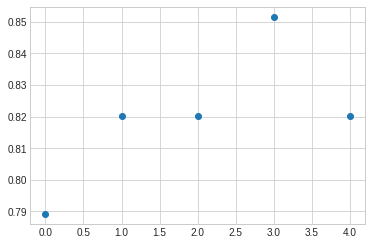

In [ ]:
parameter_tunning_naive_baiyes(X_train, Y_train)

best lambda for logistic regresion is: 19952.62314968891


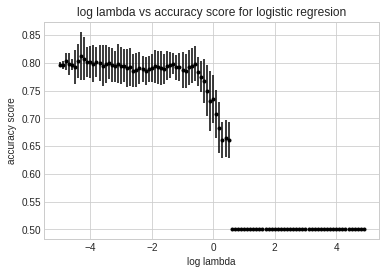

In [ ]:
best_lambda = parameter_tunning_logistic_regresion(X_train, Y_train)
# best lambda for logistic regresion is: 39810.71705534986

In [ ]:
max_features, n_estimators = parameter_tunning_random_forest(X_train, Y_train)
# Best: 0.870000 using {'max_features': 'log2', 'n_estimators': 730}

In [ ]:
alpha = parameter_tunning_decision_tree(X_train, Y_train)
# best aplha for decision tree cost complexity prunning is: 0.01516109606759828

In [ ]:
parameters = {'lambda': best_lambda, 'max_features': max_features, 'n_estimators': n_estimators, 'alpha': alpha}

In [ ]:
# getting the most confident features
logistic_regression = LogisticRegression(
                                          random_state=0,
                                          solver='liblinear', 
                                          penalty='l1',
                                          C = parameters['lambda']
                                          ).fit(X_train, Y_train)
Y_pred = logistic_regression.predict(X_test)
print(f'acc: {accuracy_score(Y_pred,Y_test)}')
weights = logistic_regression.coef_[0].tolist()
features_0 = []
features_1 = []
for i in range(10):
  max = np.max(weights)
  min = np.min(weights)
  features_0.append(feature_names[weights.index(max)])
  features_1.append(feature_names[weights.index(min)])
  weights.remove(max)
  weights.remove(min)
print(features_0, 'top for truthful')
print(features_1, 'top for deceptive')


# Testing models


In [ ]:
# pretrained params in order to skip cross validation
parameters = {
              'lambda':39810.71705534986,
              'max_features': 'log2', 
              'n_estimators': 730, 
              'alpha': 0.01516109606759828
              }

In [ ]:
naive_bayes = MultinomialNB().fit(X_train, Y_train)

logistic_regression = LogisticRegression(
                                          random_state=0,
                                          solver='liblinear', 
                                          penalty='l1',
                                          C = parameters['lambda']
                                          ).fit(X_train, Y_train)

decision_tree = DecisionTreeClassifier(
                                        random_state=0,
                                        ccp_alpha=parameters['alpha']
                                        ).fit(X_train,Y_train)

random_forest = RandomForestClassifier(
                                        max_features=parameters['max_features'],
                                        n_estimators = parameters['n_estimators'],
                                        random_state=0
                                        ).fit(X_train,Y_train)

# predicting
Y_pred = naive_bayes.predict(X_test)
print(f'Naive Bayes')
evaluate_pred(Y_test, Y_pred)

Y_pred = logistic_regression.predict(X_test)  
print(f'Logistic Regression')
evaluate_pred(Y_test, Y_pred)

Y_pred = decision_tree.predict(X_test)
print(f'Decision tree')
evaluate_pred(Y_test, Y_pred)

Y_pred = random_forest.predict(X_test)
print(f'Random Forest')
evaluate_pred(Y_test, Y_pred)

Naive Bayes
Number of mislabeled points out of a total 160 points : 36
acc:  0.775
precision:  0.7972972972972973
recall:  0.7375
F:  0.7662337662337663
Logistic Regression
Number of mislabeled points out of a total 160 points : 45
acc:  0.71875
precision:  0.7272727272727273
recall:  0.7
F:  0.7133757961783439
Decision tree
Number of mislabeled points out of a total 160 points : 50
acc:  0.6875
precision:  0.6704545454545454
recall:  0.7375
F:  0.7023809523809523
Random Forest
Number of mislabeled points out of a total 160 points : 36
acc:  0.775
precision:  0.782051282051282
recall:  0.7625
F:  0.7721518987341772


0.775

# Test on fold5 to see final evaluation scores

In [ ]:
# Splitting into train and test after fold5
'''
We need to create 5x2 CV
so 5 times 50% split
'''
res_NB = []
res_LR = []
res_DT = []
res_RF = []
for i in range (5):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=True)

  naive_bayes = MultinomialNB().fit(X_train, Y_train)

  logistic_regression = LogisticRegression(
                                          random_state=0,
                                          solver='liblinear', 
                                          penalty='l1',
                                          C = parameters['lambda']
                                          ).fit(X_train, Y_train)

  decision_tree = DecisionTreeClassifier(
                                        random_state=0,
                                        ccp_alpha=parameters['alpha']
                                        ).fit(X_train,Y_train)

  random_forest = RandomForestClassifier(
                                        max_features=parameters['max_features'],
                                        n_estimators = parameters['n_estimators'],
                                        random_state=0
                                        ).fit(X_train,Y_train)

  Y_pred = naive_bayes.predict(X_test)
  print(f'Naive Bayes')
  res_NB.append(evaluate_pred(Y_test, Y_pred))

  Y_pred = logistic_regression.predict(X_test)
  # print(Y_pred)
  print(f'Logistic Regression')
  res_LR.append(evaluate_pred(Y_test, Y_pred))

  Y_pred = decision_tree.predict(X_test)
  print(f'Decision tree')
  res_DT.append(evaluate_pred(Y_test, Y_pred))

  Y_pred = random_forest.predict(X_test)
  print(f'Random Forest')
  res_RF.append(evaluate_pred(Y_test, Y_pred))

print(res_NB)
print(res_LR)
print(res_DT)
print(res_RF)

Naive Bayes
Number of mislabeled points out of a total 400 points : 70
acc:  0.825
precision:  0.8369565217391305
recall:  0.7938144329896907
F:  0.8148148148148148
Logistic Regression
Number of mislabeled points out of a total 400 points : 79
acc:  0.8025
precision:  0.7804878048780488
recall:  0.8247422680412371
F:  0.8020050125313283
Decision tree
Number of mislabeled points out of a total 400 points : 134
acc:  0.665
precision:  0.6376146788990825
recall:  0.7164948453608248
F:  0.674757281553398
Random Forest
Number of mislabeled points out of a total 400 points : 76
acc:  0.81
precision:  0.7633928571428571
recall:  0.8814432989690721
F:  0.818181818181818
Naive Bayes
Number of mislabeled points out of a total 400 points : 104
acc:  0.74
precision:  0.921875
recall:  0.5566037735849056
F:  0.6941176470588236
Logistic Regression
Number of mislabeled points out of a total 400 points : 83
acc:  0.7925
precision:  0.837696335078534
recall:  0.7547169811320755
F:  0.794044665012407
De

In [ ]:
print(stats.ttest_rel(res_NB, res_DT).pvalue)
print(stats.ttest_rel(res_NB, res_LR).pvalue)
print(stats.ttest_rel(res_NB, res_RF).pvalue)
print(stats.ttest_rel(res_DT, res_LR).pvalue)
print(stats.ttest_rel(res_DT, res_RF).pvalue)
print(stats.ttest_rel(res_LR, res_RF).pvalue)

0.0031293609247162128
0.4634470834106993
0.8955643662134358
0.00026706796810035824
9.762560555621551e-05
0.15845392703924577
